In [1]:
import pandas as pd
import os
import re
import json
import yaml
from glob import glob
from tqdm import tqdm
from pprint import pprint
import torch
import pytorch_lightning as pl
from rouge import Rouge # 모델의 성능을 평가하기 위한 라이브러리입니다.

from torch.utils.data import Dataset , DataLoader
from transformers import AutoTokenizer, BartForConditionalGeneration, BartConfig
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

import wandb # 모델 학습 과정을 손쉽게 Tracking하고, 시각화할 수 있는 라이브러리입니다.

In [3]:

# 파일 경로 업데이트 후 다시 데이터 파일 불러오기
train_file_path = '../data/train.csv'
dev_file_path = '../data/dev.csv'
test_file_path = '../data/test.csv'

# 데이터 파일 불러오기
train_df = pd.read_csv(train_file_path)
dev_df = pd.read_csv(dev_file_path)
test_df = pd.read_csv(test_file_path)

# 각 데이터셋의 크기 확인
train_shape = train_df.shape
dev_shape = dev_df.shape
test_shape = test_df.shape

# 각 데이터셋의 첫 5행 확인
train_head = train_df.head()
dev_head = dev_df.head()
test_head = test_df.head()

train_shape, dev_shape, test_shape, train_head, dev_head, test_head


((12457, 4),
 (499, 4),
 (499, 2),
      fname                                           dialogue  \
 0  train_0  #Person1#: 안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나...   
 1  train_1  #Person1#: 안녕하세요, 파커 부인, 어떻게 지내셨나요?\n#Person2#...   
 2  train_2  #Person1#: 실례합니다, 열쇠 한 묶음 보셨나요?\n#Person2#: 어떤...   
 3  train_3  #Person1#: 왜 너는 여자친구가 있다는 걸 말해주지 않았어?\n#Person...   
 4  train_4  #Person1#: 안녕, 숙녀분들! 오늘 밤 당신들은 정말 멋져 보여. 이 춤을 ...   
 
                                              summary     topic  
 0  스미스씨가 건강검진을 받고 있고, 호킨스 의사는 매년 건강검진을 받는 것을 권장합니...   건강검진 받기  
 1  파커 부인이 리키를 데리고 백신 접종을 하러 갔다. 피터스 박사는 기록을 확인한 후...        백신  
 2  #Person1#은 열쇠 한 묶음을 찾고 있고, 그것을 찾기 위해 #Person2#...     열쇠 찾기  
 3  #Person1#은 #Person2#가 여자친구가 있고 그녀와 결혼할 것이라는 사실...  여자친구가 있다  
 4  말릭이 니키에게 춤을 요청한다. 말릭이 발을 밟는 것을 신경 쓰지 않는다면 니키는 ...        댄스  ,
    fname                                           dialogue  \
 0  dev_0  #Person1#: 안녕하세요, 오늘 하루 어떠셨어요? \n#Person2#: 요즘...   
 1  dev_1  #Person1#: 헤이, 지미. 나중에 운동하러 가자.

In [15]:
# 필요한 re 라이브러리를 임포트합니다.
import re

# 다시 'dialogue_len' 열 생성 코드를 실행해 봅니다.
train_df['dialogue_len'] = train_df['dialogue'].apply(lambda x: len(x.split()))

# 에러 발생 이유 중 하나로 지목된 'dialogue_len' 열이 정상적으로 생성되었는지 확인
'dialogue_len' in train_df.columns

# 'summary_len' 열 생성 코드를 다시 실행합니다.
train_df['summary_len'] = train_df['summary'].apply(lambda x: len(x.split()))

# 'summary_len' 열이 정상적으로 생성되었는지 확인
'summary_len' in train_df.columns



# 다시 기초 통계량 및 주제별 분포 확인
dialogue_len_stats = train_df['dialogue_len'].describe()
summary_len_stats = train_df['summary_len'].describe()
num_participants_stats = train_df['num_participants'].describe()

topic_distribution = train_df['topic'].value_counts()

dialogue_len_stats, summary_len_stats, num_participants_stats, topic_distribution.head(10)  # 주제별 분포 상위 10개만 보여줍니다.

(count    12457.000000
 mean        90.659469
 std         48.952439
 min         20.000000
 25%         58.000000
 50%         80.000000
 75%        113.000000
 max        606.000000
 Name: dialogue_len, dtype: float64,
 count    12457.000000
 mean        16.917958
 std          7.845674
 min          4.000000
 25%         11.000000
 50%         16.000000
 75%         21.000000
 max         99.000000
 Name: summary_len, dtype: float64,
 count    12457.000000
 mean         2.011801
 std          0.130849
 min          2.000000
 25%          2.000000
 50%          2.000000
 75%          2.000000
 max          7.000000
 Name: num_participants, dtype: float64,
 topic
 일상 대화     236
 쇼핑        188
 전화 통화      98
 직업 면접      92
 음식 주문      85
 인터뷰        75
 길 묻기       70
 영화         48
 사회적 만남     46
 체크인        46
 Name: count, dtype: int64)

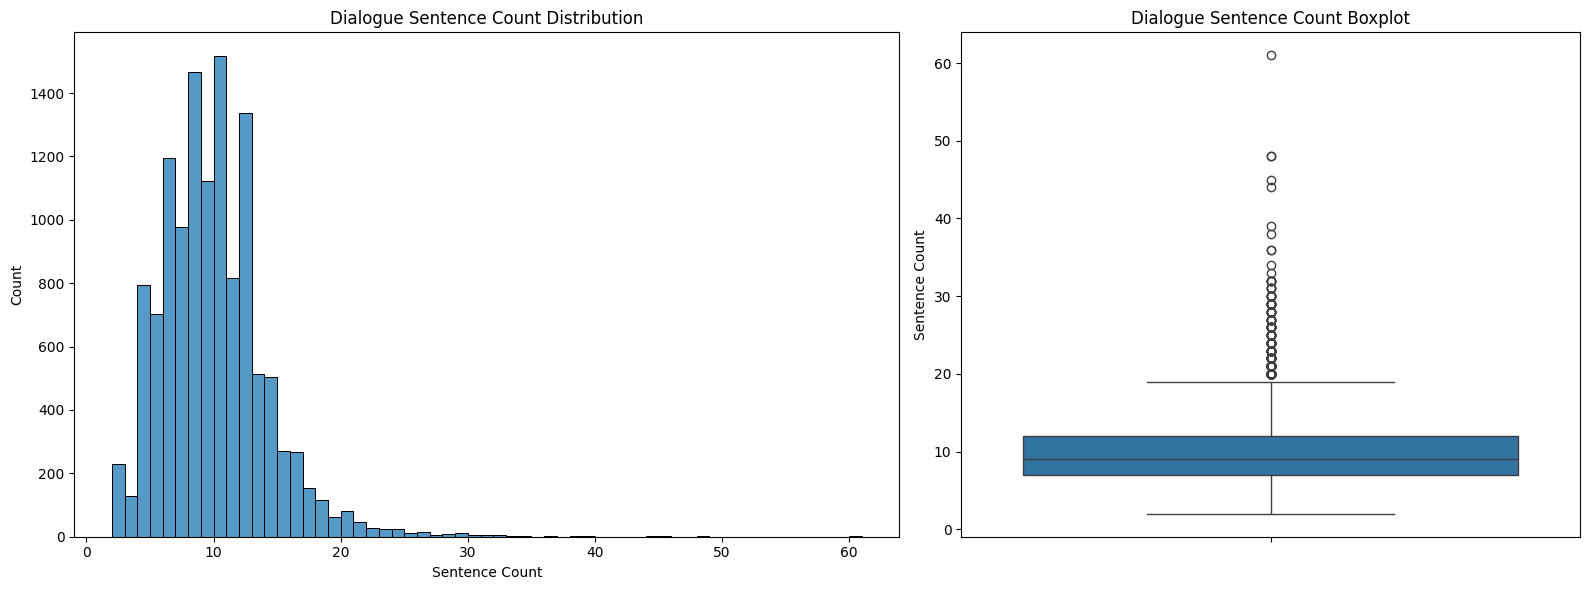

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 대화 내용을 문장으로 나누고, 각 대화에서 문장의 개수를 계산
train_df['sent_count'] = train_df['dialogue'].apply(lambda x: len(x.split('\n')))

# 시각화
fig, axs = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw=dict(width_ratios=[4, 3]))
sns.histplot(train_df['sent_count'], binwidth=1, ax=axs[0])
sns.boxplot(y=train_df['sent_count'], ax=axs[1])

axs[0].set_title('Dialogue Sentence Count Distribution')
axs[1].set_title('Dialogue Sentence Count Boxplot')
axs[0].set_xlabel('Sentence Count')
axs[1].set_ylabel('Sentence Count')
plt.tight_layout()
plt.show()


In [13]:
# 문장 수에 대한 기초 통계량 계산
sent_count_stats = train_df['sent_count'].describe()

sent_count_stats


count    12457.000000
mean         9.490728
std          4.150287
min          2.000000
25%          7.000000
50%          9.000000
75%         12.000000
max         61.000000
Name: sent_count, dtype: float64

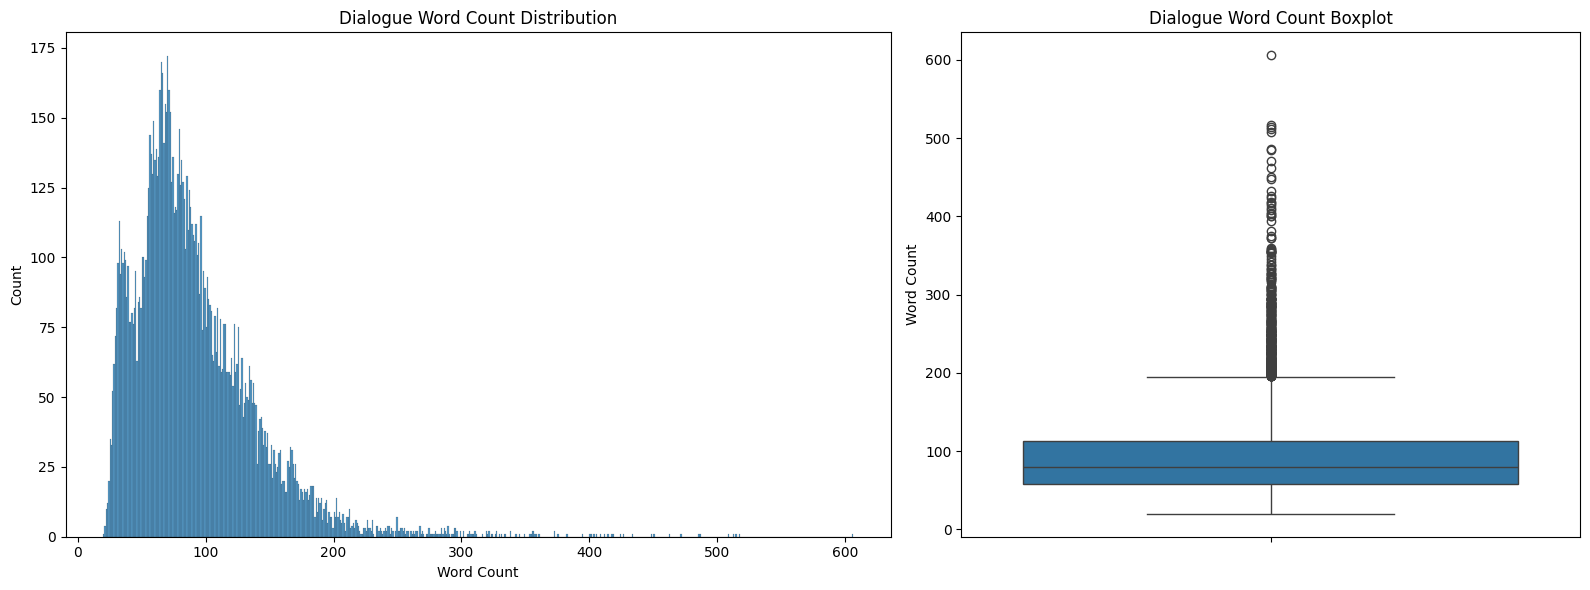

In [16]:
# 각 대화에서 단어 수 계산
train_df['word_count'] = train_df['dialogue'].apply(lambda x: len(x.split()))

# 시각화
fig, axs = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw=dict(width_ratios=[4, 3]))
sns.histplot(train_df['word_count'], binwidth=1, ax=axs[0])
sns.boxplot(y=train_df['word_count'], ax=axs[1])

axs[0].set_title('Dialogue Word Count Distribution')
axs[1].set_title('Dialogue Word Count Boxplot')
axs[0].set_xlabel('Word Count')
axs[1].set_ylabel('Word Count')
plt.tight_layout()
plt.show()


In [17]:
# 단어 수에 대한 기초 통계량 계산
word_count_stats = train_df['word_count'].describe()

word_count_stats


count    12457.000000
mean        90.659469
std         48.952439
min         20.000000
25%         58.000000
50%         80.000000
75%        113.000000
max        606.000000
Name: word_count, dtype: float64